# Movie Clustering and Topic Modeling

In this project, I use unsupervised learning models (k-means and lda) to cluster Top 250 movies crawled from IMDB into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing, Stemming and TF-IDF](#Part-2:-Tokenizing,-Stemming-and-TF-IDF)
<li>[Part 3: K-means clustering](#Part-3:-K-means-clustering)
<li>[Part 4: Topic Modeling - Latent Dirichlet Allocation](#Part-4:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

## Part 1: Load Data

In [108]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [109]:
# import crawled data: movie titles and synopses
titles = open('data/titles.txt').read().split('\n')
titles = titles[:250]
synopses = open('data/synopses.txt').read().split('BREAKS HERE\n')
synopses = synopses[:250]

#Since these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing, Stemming and TF-IDF

Load stopwords and stemmer function from NLTK library. Then do TF-IDF to generate features.

In [110]:
from nltk.stem.snowball import SnowballStemmer

# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
print "We use " + str(len(stopwords)) + " stop-words from nltk library."

stemmer = SnowballStemmer("english")

# define tokenization and stemming function
def tokenization_and_stemming(text):
    """
    For a text file, we need to do tokenization and then do stemming.
    """
    # sent_tokenize extracts the sentence and word_tokenize extracts the words
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for 
              word in nltk.word_tokenize(sent) if word not in stopwords]
 
    filtered_tokens = []
    # filter out any tokens not containing letters
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    """
    Just do tokenization without stemming
    """
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for 
              word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

We use 153 stop-words from nltk library.


In [111]:
tokenization_and_stemming("She looked at her father's face. He looked good.")

[u'she', u'look', u'father', "'s", u'face', 'he', u'look', u'good']

In [112]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i.decode('utf-8'))
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i.decode('utf-8'))
    docs_tokenized.extend(tokenized_results)
    
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in xrange(len(docs_stemmed))}
print len(docs_stemmed)
print vocab_frame_dict['walk']

295577
walk


In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 250 synoposes and 1115 terms.


In [114]:
tf_selected_words = tfidf_model.get_feature_names()
tfidf_model.get_params()

{'analyzer': u'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.1,
 'ngram_range': (1, 1),
 'norm': u'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

# Part 3: K-means Clustering

In [115]:
from sklearn.cluster import KMeans

num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 3.1. Analyze K-means Result

In [116]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])
frame.head(10)

,rank,title,cluster
2,0,The Shawshank Redemption,2
3,1,The Godfather,3
3,2,The Godfather: Part II,3
2,3,The Dark Knight,2
3,4,12 Angry Men,3
3,5,Schindler's List,3
2,6,Pulp Fiction,2
3,7,The Lord of the Rings: The Return of the King,3
3,8,"The Good, the Bad and the Ugly",3
4,9,Fight Club,4


In [117]:
print "Number of films included in each cluster:"
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
4,75
3,60
2,52
5,38
0,14
1,11


In [118]:
grouped = frame['rank'].groupby(frame['cluster'])
print "Average rank (1 to 250) per cluster:"
grouped.mean().to_frame()

Average rank (1 to 250) per cluster:


,rank
cluster,
0,94.214286
1,161.363636
2,119.519231
3,108.833333
4,131.920000
5,141.894737


In [119]:
print "<Document clustering result by K-means>"

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print tf_selected_words[ind] + ',',
#         Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
#         print vocab_frame_dict[tf_selected_words[ind]] + ",",
    print
    #Here ix means index, which is the clusterID of each item.
    #tolist convert <type 'numpy.ndarray'> to list
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print "Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " 
    print ", ".join(cluster_movies)
    print

<Document clustering result by K-means>
Cluster 0 words: frank, ship, space, earth, star, destroy,
Cluster 0 titles (14 movies): 
Star Wars: Episode V - The Empire Strikes Back, Star Wars: Episode IV - A New Hope, Once Upon a Time in the West, Interstellar, Alien, WALL·E, Aliens, Star Wars: Episode VI - Return of the Jedi, 2001: A Space Odyssey, Scarface, Metropolis, Catch Me If You Can, Donnie Darko, Star Wars: The Force Awakens

Cluster 1 words: page, button, guid, titl, learn, like,
Cluster 1 titles (11 movies): 
Modern Times, The Kid, Babam ve Oglum, Ikiru, The Bandit, Come and See, Relatos salvajes, The 400 Blows, Nausicaä of the Valley of the Wind, La Haine, 8½

Cluster 2 words: polic, kill, tell, joe, harri, gang,
Cluster 2 titles (52 movies): 
The Shawshank Redemption, The Dark Knight, Pulp Fiction, Goodfellas, Se7en, The Silence of the Lambs, The Usual Suspects, City Lights, The Intouchables, The Departed, Terminator 2, Memento, Sunset Blvd., The Dark Knight Rises, Oldeuboi, O

In [120]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
# tfidf_matrix is a sparse matrix
tfidf_matrix_np = tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'y'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

## 3. 2. K-means Result Visulization

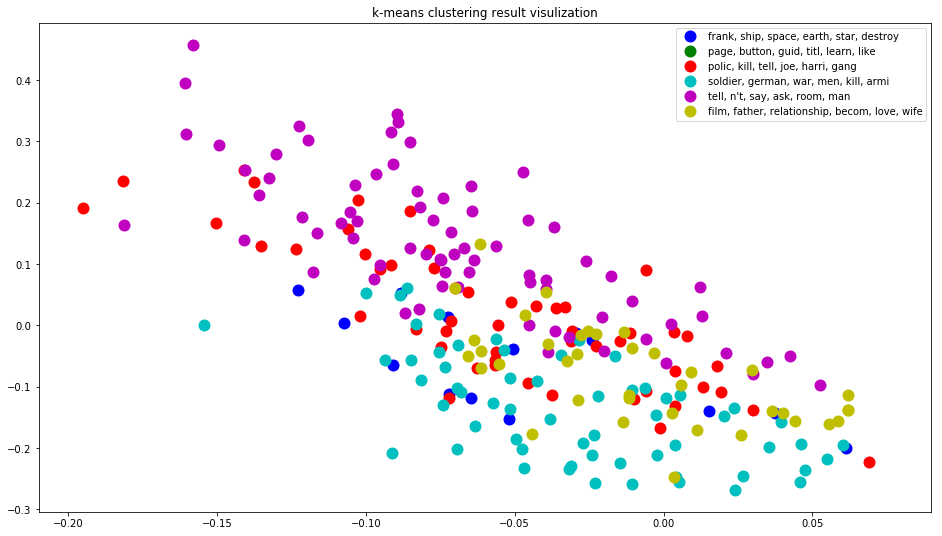

In [121]:
#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
ax.set_xlim([-0.21, 0.09])
plt.title('k-means clustering result visulization')
ax.legend(numpoints=1,loc=1)  #show legend with only 1 point, position is right bottom.
plt.show() #show the plot

In [122]:
plt.close()

# Part 4: Topic Modeling - Latent Dirichlet Allocation

In [123]:
import lda

#Now we use synopses to build a 100*551 matrix (terms)
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i.decode('utf-8'))
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

model = lda.LDA(n_topics=6, n_iter=500, random_state=1)

model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 250
INFO:lda:vocab_size: 1115
INFO:lda:n_words: 139264
INFO:lda:n_topics: 6
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -1209640
INFO:lda:<10> log likelihood: -1081516
INFO:lda:<20> log likelihood: -1034875
INFO:lda:<30> log likelihood: -1017359
INFO:lda:<40> log likelihood: -1009519
INFO:lda:<50> log likelihood: -1005158
INFO:lda:<60> log likelihood: -1001576
INFO:lda:<70> log likelihood: -999686
INFO:lda:<80> log likelihood: -996927
INFO:lda:<90> log likelihood: -994175
INFO:lda:<100> log likelihood: -993717
INFO:lda:<110> log likelihood: -991968
INFO:lda:<120> log likelihood: -991865
INFO:lda:<130> log likelihood: -990197
INFO:lda:<140> log likelihood: -989142
INFO:lda:<150> log likelihood: -988005
INFO:lda:<160> log likelihood: -987601
INFO:lda:<170> log likelihood: -987018
INFO:lda:<180> log likelihood: -984753
INFO:lda:<190> log likelihood: -984904
INFO:lda:<200> log likelihood: -983619
INFO:lda:<210> log likelihood: -982993
INFO:lda:<220> log likeliho

## 4.1. Analyze LDA Topic Modeling Result

In [124]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

ida_clusters = []
print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    ida_clusters.append(topicID)
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " 
    print ', '.join(topic_doc_dict[i])
    print

<Document clustering result by LDA>
Cluster 0 words: tells, n't, says, asks, coming, looks
Cluster 0 titles (118 movies): 
The Shawshank Redemption, The Dark Knight, Pulp Fiction, Inception, The Matrix, It's a Wonderful Life, Léon: The Professional, Spirited Away, American History X, Once Upon a Time in the West, Interstellar, The Green Mile, Psycho, City Lights, Rear Window, Back to the Future, Whiplash, The Prestige, The Lion King, The Lives of Others, Paths of Glory, Django Unchained, The Shining, Blade Runner 2049, American Beauty, Princess Mononoke, Oldeuboi, Das Boot, Citizen Kane, Vertigo, North by Northwest, Requiem for a Dream, Taare Zameen Par, A Clockwork Orange, Kimi no na wa., Double Indemnity, To Kill a Mockingbird, 2001: A Space Odyssey, Singin' in the Rain, Toy Story, Toy Story 3, The Sting, Snatch, Monty Python and the Holy Grail, For a Few Dollars More, A Separation, Rashômon, All About Eve, Yojimbo, Up, Batman Begins, Some Like It Hot, The Treasure of the Sierra Madr

## 4.2. LDA Result Visulization

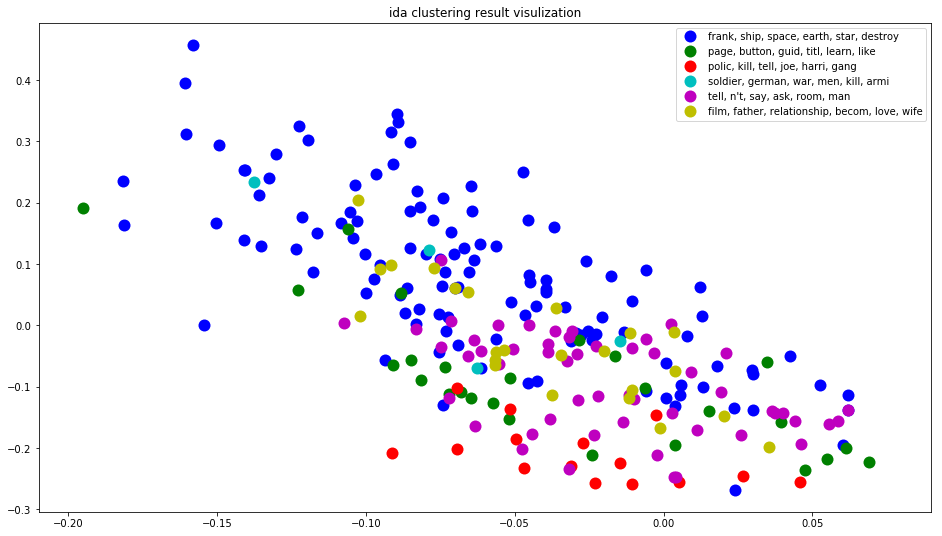

In [125]:
#create data frame with PCA cluster results
ida_df = pd.DataFrame(dict(x=xs, y=ys, label=ida_clusters, title=titles)) 
ida_groups = ida_df.groupby(ida_clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in ida_groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.set_xlim([-0.21, 0.09])
ax.legend(numpoints=1,loc=1)  #show legend with only 1 point, position is right bottom.
plt.title('ida clustering result visulization')

plt.show() #show the plot

In [126]:
plt.close()